# Assignment 6

This assignment has weighting $3.5$.
The first question about clustering has 35%, and the second question about tiny image classification has 65%.

This is a challenging assignment, so I recommend you start early.

# Clustering for handwritten digits

Supervised learning requires labeled data, which can be expensive to acquire.
For example, a dataset with $N$ samples for classification will require manual labeling $N$ times.

One way to ameliorate this issue is to perform clustering of the raw data samples first, followed by manual inspection and labeling of only a few samples.
Recall that clustering is a form of non-supervised learning, so it does not require any class labels.

For example, say we are given a set of scanned hand-written digit images.
We can cluster them into 10 groups first, manually inspect and label a few images in each cluster, and propagate the label towards the rest of all (unlabeled) samples in each cluster.

The accuracy of such semi-automatic labeling depends on the accuracy of the clustering.
If each cluster (0 to 9) corresponds exactly to hand-written digits 0-9, we are fine.
Otherwise, we have some mis-labeled data.

The goal of this question is to exercise clustering of the scikit-learn digits dataset which has labels, so that we can verify our clustering accuracy.
The specifics are as follows.

You will be judged by the test accuracy of your code, and quality of descriptions of your method.
As a reference, a simple code I (Li-Yi) wrote can achieve about 78% accuracy. Try to beat it as much as you can.

## Training and test data split

We will split the original dataset into training and test datasets
* training for building our clusters
* testing to see if the clusters can predict future data

## Accuracy
What is your clustering accuracy (comparing cluster labels with the ground truth labels), and what are the properties of mis-clustered samples?

## Data preprocessing
Would the original features (pixels) work well, or we need further processing like scaling/standardization or dimensionality-reduction, before clustering?

## Models and hyper-parameters

Let's focus on k-means clustering, as hierarchical and density-based clustering do not provide the predict() method under scikit-learn.

What is the best test performance you can achieve with which hyper-parameters (for k-means, standard scalar, and dimensionality reduction)?

### Hint
We have learned Pipeline and GridSearchCV for cross validation and hyper-parameter tuning.

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,pandas,matplotlib,scipy,sklearn
%matplotlib inline

last updated: 2016-12-14 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.3
scipy 0.18.1
sklearn 0.17.1


In [2]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

## Load data

In [3]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data # data in pixels
y = digits.target # digit labels

print(X.shape)
print(y.shape)

print(np.unique(y))

(1797, 64)
(1797,)
[0 1 2 3 4 5 6 7 8 9]


## Visualize data

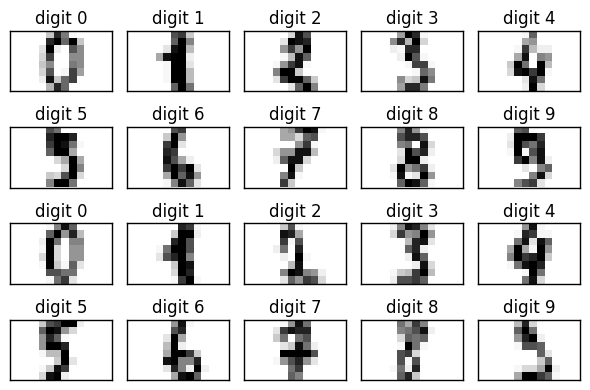

In [4]:
import matplotlib.pyplot as plt
import pylab as pl

num_rows = 4
num_cols = 5

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, sharey=True)
ax = ax.flatten()
for index in range(num_rows*num_cols):
    img = digits.images[index]
    label = digits.target[index]
    ax[index].imshow(img, cmap='Greys', interpolation='nearest')
    ax[index].set_title('digit ' + str(label))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Data sets: training versus test

In [5]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split
    
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

num_training = y_train.shape[0]
num_test = y_test.shape[0]
print('training: ' + str(num_training) + ', test: ' + str(num_test))

training: 1257, test: 540


In [6]:
import numpy as np

# check to see if the data are well distributed among digits
for y in [y_train, y_test]:
    print(np.bincount(y))

[119 133 128 119 120 135 130 122 128 123]
[59 49 49 64 61 47 51 57 46 57]


## Answer

We first write a scoring function for clustering so that we can use for GridSearchCV.
Take a look at use_scorer under scikit learn.

In [7]:
from sklearn.metrics import accuracy_score, make_scorer

def clustering_accuracy_score(y_true, y_pred):
    # replace this with your code; note that y_pred is just cluster id, not digit id
    y_cm = y_pred
    cluster_label_true = np.unique(y_true)
    cluster_num_true = len(cluster_label_true)
    cluster_label_cm = np.unique(y_cm)
    cluster_num_cm = len(cluster_label_cm)
    
    scores = np.zeros((cluster_num_cm, cluster_num_true))
    
    for i in range(cluster_num_cm):
        for j in range(cluster_num_true):
            y_temp = y_true[y_cm == cluster_label_cm[i]]
            y_count = len(y_temp)
            scores[i][j] = accuracy_score(y_true = y_temp, y_pred = cluster_label_true[j] * np.ones(y_count))
    
    best_assign_index = np.zeros(cluster_num_cm)
    
    for i in range(cluster_num_cm):
        best_assign_index[i] = np.argmax(scores[i])
    
    y_predict = np.zeros(len(y_cm))
    for i, v in enumerate(y_cm):
        index = np.where(cluster_label_cm == v)[0][0]
        y_predict[i] = best_assign_index[index]
    
    return accuracy_score(y_true=y_true, y_pred=y_predict)

clustering_accuracy = make_scorer(clustering_accuracy_score) 

In [8]:
# toy case demonstrating the clustering accuracy
# this is just a reference to illustrate what this score function is trying to achieve
# feel free to design your own as long as you can justify

# ground truth class label for samples
toy_y_true = np.array([0, 0, 0, 1, 1, 2])

# clustering id for samples
toy_y_pred_true = np.array([1, 1, 1, 2, 2, 0])
toy_y_pred_bad1 = np.array([0, 0, 1, 1, 1, 2])
toy_y_pred_bad2 = np.array([2, 2, 1, 0, 0, 0])

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_true)
print('accuracy', toy_accuracy, ', should be 1')

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad1)
print('accuracy', toy_accuracy, ', should be', 5.0/6.0)

toy_accuracy = clustering_accuracy_score(toy_y_true, toy_y_pred_bad2)
print('accuracy', toy_accuracy, ', should be', 4.0/6.0)

accuracy 1.0 , should be 1
accuracy 0.833333333333 , should be 0.8333333333333334
accuracy 0.833333333333 , should be 0.6666666666666666


Build a pipeline with standard scaler, PCA, and clustering.

In [9]:
# your code
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

# construct a pipeline consisting of different components
# each entry contains an identifier, and the corresponding component
pipe_km = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA()),
                    ('km', KMeans(random_state=0))])

Use GridSearchCV to tune hyper-parameters.

In [10]:
# your code
if Version(sklearn_version) < '0.18':
    from sklearn.grid_search import GridSearchCV
else:
    from sklearn.model_selection import GridSearchCV

param_grid = {'scl__with_mean': [True, False],
              'scl__with_std': [True, False],
              'pca__n_components': np.array(range(20,40,2)),
              'km__n_clusters': np.array(range(10,20)),
              'km__init': ['k-means++', 'random']}
    
gs = GridSearchCV(estimator=pipe_km, 
                  param_grid=param_grid, 
                  scoring=clustering_accuracy, 
                  cv=10,
                  n_jobs=1)

gs = gs.fit(X_train, y_train)

# # below is Li-Yi's dummy code to build a random guess model
# import numpy as np
# class RandomGuesser:
#     def __init__(self, num_classes):
#         self.num_classes = num_classes
#     def predict(self, X):
#         y = np.random.randint(low = 0, high = self.num_classes, size = X.shape[0])
#         return y

In [12]:
best_model = gs.best_estimator_ # replace this with the best model you can build

y_cm = best_model.predict(X_test)

print('Test accuracy: %.3f' % clustering_accuracy_score(y_true=y_test, y_pred=y_cm))

#print('Test accuracy: %.3f' % best_model.score(X_test, y_test))

Test accuracy: 0.930


Visualize mis-clustered samples, and provide your explanation.

In [12]:
# your code

your explanation

# Tiny image classification

We will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for image object recognition.
The dataset consists of 50000 training samples and 10000 test samples in 10 different classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck; see the link above for more information).
The goal is to maximize the accuracy of your classifier on the test dataset after being optimized via the training dataset.

You can use any learning models (supervised or unsupervised) or optimization methods (e.g. search methods for hyper-parameters).
The only requirement is that your code can run inside an ipynb file, as usual.
Please provide a description of your method, in addition to the code.
Your answer will be evaluated not only on the test accuracy but also on the creativity of your methodology and the quality of your explanation/description.

## Sample code to get you started

This is a difficult classification task.
A sample code below, based on a simple fully connected neural network built via Keras, is provided below.
The test accuracy is about 43%.

In [1]:
%load_ext watermark
%watermark -a '' -u -d -v -p numpy,keras

Using Theano backend.


last updated: 2016-11-12 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
keras 1.1.1


In [49]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
import numpy as np
from sklearn.metrics import accuracy_score

# load data set
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

img_shape = X_train.shape[1:] # [num_rows, num_cols, num_channels]
num_img_pixels = np.prod(img_shape)
num_training_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]

nb_classes = np.sum(np.unique(y_train).shape)

print('image shape: ', img_shape)
print(X_train.shape[0], 'training samples')
print(X_test.shape[0], 'test samples')
print(nb_classes, 'classes')

# data processing

# X_train = X_train.reshape(num_training_samples, num_img_pixels)
# X_test = X_test.reshape(num_test_samples, num_img_pixels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one hot encoding of labels
y_train_ohe = np_utils.to_categorical(y_train)
y_test_ohe = np_utils.to_categorical(y_test)

image shape:  (32, 32, 3)
50000 training samples
10000 test samples
10 classes


In [16]:
# build a basic network

model = Sequential()

model.add(Dense(input_dim = num_img_pixels, 
                output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = 50, 
                init = 'uniform', 
                activation = 'tanh'))

model.add(Dense(output_dim = nb_classes, 
                init = 'uniform', 
                activation = 'softmax'))

sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

model.compile(loss = 'categorical_crossentropy', 
              optimizer = sgd, 
              metrics = ["accuracy"])


In [19]:
# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 5, 
              batch_size = 10, 
              verbose = False, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

SystemError: <class 'range'> returned a result with an error set
Apply node that caused the error: Elemwise{Composite{((i0 * i1) - (i2 / i3))}}[(0, 1)](InplaceDimShuffle{x,x}.0, <TensorType(float32, matrix)>, Dot22Scalar.0, InplaceDimShuffle{x,x}.0)
Toposort index: 71
Inputs types: [TensorType(float32, (True, True)), TensorType(float32, matrix), TensorType(float32, matrix), TensorType(float32, (True, True))]
Inputs shapes: [(1, 1), (3072, 50), (3072, 50), (1, 1)]
Inputs strides: [(4, 4), (200, 4), (200, 4), (4, 4)]
Inputs values: [array([[ 0.89999998]], dtype=float32), 'not shown', 'not shown', array([[ 1.]], dtype=float32)]
Outputs clients: [['output', Elemwise{Add}[(0, 0)](dense_4_W, Elemwise{Composite{((i0 * i1) - (i2 / i3))}}[(0, 1)].0)]]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [ ]:
# evaluate

y_train_pred = model.predict_classes(X_train, verbose=False)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = model.predict_classes(X_test, verbose=False)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)


## Answer

In [53]:
# your code and experimental results
# define a training model
from keras.models import Sequential
model = Sequential()

# number of convolutional filters
n_filters = 32

# convolution filter size
n_conv = 6

# pooling window size
n_pool = 4

In [54]:
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten, Dense

model.add(Convolution2D(
        n_filters, n_conv, n_conv,

        # apply the filter to only full parts of the image
        # (i.e. do not "spill over" the border)
        # this is called a narrow convolution
        border_mode='valid',

        # we have a 32x32 rgb channel (grayscale) image
        # so the input shape should be (32, 32, 3)
        input_shape=(32, 32, 3),
        
        dim_ordering='tf'
))
model.add(Activation('relu'))

model.add(Convolution2D(n_filters, n_conv, n_conv))
model.add(Activation('relu'))

# then we apply pooling to summarize the features
# extracted thus far
model.add(MaxPooling2D(pool_size=(n_pool, n_pool)))


model.add(Dropout(0.25))

# flatten the data for the 1D layers
model.add(Flatten())

# Dense(n_outputs)
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# the softmax output layer gives us a probablity for each class
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# train

_ = model.fit(X_train, y_train_ohe, 
              nb_epoch = 30, 
              batch_size = 256, 
              verbose = True, # turn this on to visualize progress 
              validation_split = 0.1 # 10% of training data for validation per epoch
             )

Train on 45000 samples, validate on 5000 samples
Epoch 1/30


In [ ]:
# evaluate

y_train_pred = newmodel.predict_classes(X_train, verbose=False)
print('First few predictions: ', y_train_pred[:3])
train_acc = accuracy_score(y_train, y_train_pred)
print('Training accuracy:', train_acc)

y_test_pred = newmodel.predict_classes(X_test, verbose=False)
test_acc = accuracy_score(y_test, y_test_pred)
print('Test accuracy:', test_acc)

## Your description
with the following main parts:

<dl>

<dt>Introduction</dt>
<dd>
At a high-level, what are the approaches you considered and why?
</dd>

<dt>Method</dt>
<dd>
Describe your entire pipeline, such as data-preprocessing, model selection, and hyper-parameter optpimization.
</dd>

<dt>Results</dt>
<dd>
Describe the experimental process you took to arrive at the solution.
For example:
(1) compare your approach against other approach(es) you have tried, as
well as the MLP baseline classifer.
(2) compare against different settings of model parameters, e.g. regularization type/strength, number of hidden units or structure of a neural network, types of kernel in a SVM, etc. 

<dt>Conclusion</dt>
<dd>
Summarize what you have learned from the experiments and discuss the limitations and potential future improvements of your current method.
</dd>

<dt>References</dt>
<dd>
Cite any publically available code, blog posts, research papers, etc. you used or got ideas from.
</dl>